In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt

OOF_DIR = "../experiments/oof_results"
LB_LOG_PATH = "../experiments/lb_scores.csv"

if not os.path.exists("../experiments"):
    os.makedirs("../experiments")

# Initialize LB log if missing
if not os.path.isfile(LB_LOG_PATH):
    pd.DataFrame([
        {"run_name": None, "mean_cv": None, "oof_score": None, "kaggle_lb": None}
    ]).to_csv(LB_LOG_PATH, index=False)


In [2]:
def load_oof_metrics(oof_dir=OOF_DIR):
    out = []
    for root, dirs, files in os.walk(oof_dir):
        if "oof_metrics.json" in files:
            name = os.path.basename(root)
            with open(os.path.join(root, "oof_metrics.json"), "r") as f:
                m = json.load(f)
            out.append({
                "run_name": name,
                "mean_cv": m.get("mean_cv"),
                "oof_score": m.get("oof_score")
            })
    return pd.DataFrame(out)

cv_df = load_oof_metrics()
cv_df.sort_values("mean_cv", ascending=False)


,run_name,mean_cv,oof_score
24,mini_smoke,0.454017,0.454002
5,gate_pass_TRUE,0.423427,0.423433
3,base_wgroupkfold,0.402492,0.402479
39,oof_tv_0p10_cls1p0_cnb_tk1_mm0p002_pr0p02_m0p5,0.337871,0.337863
20,mini_presence_0p45_topk1,0.334401,0.334425
21,mini_presence_0p5,0.324073,0.324099
32,mini_tv_0p10_cls1p0_cnb,0.274133,0.274133
23,mini_qscore_0p5,0.188383,0.188435
22,mini_qscore_0p15_minmass_0p002,0.186035,0.186009
37,oof_lossv2_cls_up2_authpen_weak1_e25,0.180529,0.180536


In [3]:
run_name = input("Run/experiment name: ").strip()
lb_score = float(input("Kaggle LB score: "))

lb_df = pd.read_csv(LB_LOG_PATH)

# Pull the matching experiment from CV results
match = cv_df[cv_df.run_name == run_name]
if len(match) == 0:
    print("⚠️ No local run found. Logging LB only.")
    new_row = {
        "run_name": run_name,
        "mean_cv": None,
        "oof_score": None,
        "kaggle_lb": lb_score
    }
else:
    m = match.iloc[0]
    new_row = {
        "run_name": run_name,
        "mean_cv": m.mean_cv,
        "oof_score": m.oof_score,
        "kaggle_lb": lb_score
    }

# Update CSV
lb_df = pd.concat([lb_df, pd.DataFrame([new_row])], ignore_index=True)
lb_df.to_csv(LB_LOG_PATH, index=False)

print("Logged:")
new_row


Logged:


{'run_name': 'oof_tv_0p10_cls1p0_cnb_tk1_mm0p002_pr0p02_m0p5',
 'mean_cv': np.float64(0.3378709368035901),
 'oof_score': np.float64(0.33786274290819746),
 'kaggle_lb': 0.196}

In [4]:
lb_df = pd.read_csv(LB_LOG_PATH).dropna(subset=["run_name"], how="all")
lb_df.sort_values("kaggle_lb", ascending=False)


,run_name,mean_cv,oof_score,kaggle_lb
1,oof_tv_0p10_cls1p0_cnb_tk1_mm0p002_pr0p02_m0p5,0.337871,0.337863,0.196


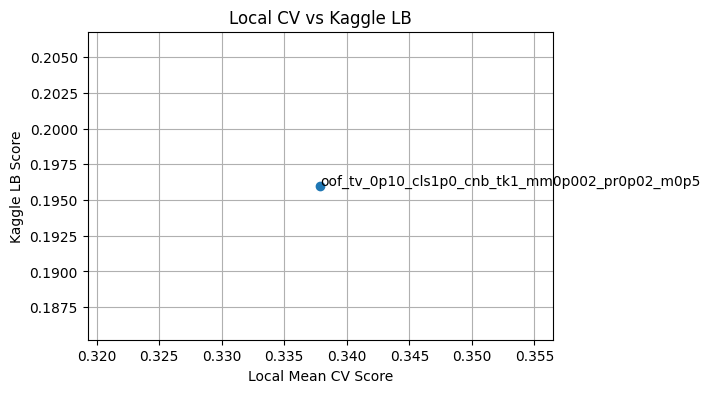

In [5]:
df = lb_df.dropna(subset=["mean_cv", "kaggle_lb"])

plt.figure(figsize=(6,4))
plt.scatter(df["mean_cv"], df["kaggle_lb"])
plt.xlabel("Local Mean CV Score")
plt.ylabel("Kaggle LB Score")
plt.title("Local CV vs Kaggle LB")
for _, r in df.iterrows():
    plt.annotate(r.run_name, (r.mean_cv, r.kaggle_lb))
plt.grid(True)
plt.show()


In [6]:
lb_df.sort_values("kaggle_lb", ascending=False).reset_index(drop=True)


,run_name,mean_cv,oof_score,kaggle_lb
0,oof_tv_0p10_cls1p0_cnb_tk1_mm0p002_pr0p02_m0p5,0.337871,0.337863,0.196


In [ ]:
df = lb_df.copy()
df["delta_lb_cv"] = df["kaggle_lb"] - df["mean_cv"]
df.sort_values("delta_lb_cv", ascending=False)

,run_name,mean_cv,oof_score,kaggle_lb,delta_lb_cv
1,oof_tv_0p10_cls1p0_cnb_tk1_mm0p002_pr0p02_m0p5,0.337871,0.337863,0.196,-0.141871


In [ ]:
prefix = "baseline"  # or "lr", "bs", etc.
lb_df[lb_df.run_name.str.contains(prefix, na=False)]


In [ ]:
# kagglelb_analysis.ipynb — setup

import json
from pathlib import Path
from datetime import datetime

import pandas as pd

# where we'll store the running log of LB submissions
LB_LOG_PATH = Path("experiments/kaggle_lb_scores.csv")

# where your gate sweep summary was saved
GATE_SWEEP_SUMMARY_PATH = Path("experiments/auth_gate_sweep/auth_gate_sweep_summary.json")

# identify the model you’re using for submissions
MODEL_ID = "full_baseline_v1"
WEIGHTS_PATH = "weights/full_train/model_full_data_baseline.pth"


In [ ]:
def load_gate_sweep_summary(summary_path: Path = GATE_SWEEP_SUMMARY_PATH) -> pd.DataFrame:
    """
    Load auth_gate_sweep_summary.json into a DataFrame with columns:
    ['gate', 'local_score', 'csv_path'].
    """
    if not summary_path.is_file():
        raise FileNotFoundError(f"No gate sweep summary found at {summary_path}")

    with summary_path.open("r", encoding="utf-8") as f:
        data = json.load(f)

    df = pd.DataFrame(data)
    df = df.rename(columns={"score": "local_score"})
    df = df.sort_values("gate").reset_index(drop=True)
    return df

gate_sweep_df = load_gate_sweep_summary()
gate_sweep_df


In [ ]:
def load_lb_log(path: Path = LB_LOG_PATH) -> pd.DataFrame:
    """
    Load existing Kaggle LB log or create an empty one with the correct schema.
    """
    if path.is_file():
        return pd.read_csv(path)

    cols = [
        "timestamp",         # ISO timestamp when you logged it
        "submission_name",   # Kaggle submission name you used
        "model_id",          # e.g. full_baseline_v1
        "weights_path",      # where the weights came from
        "auth_gate",         # gate used for this submission
        "local_score",       # from gate sweep
        "lb_score",          # Kaggle public LB score
        "notes",             # free text
    ]
    return pd.DataFrame(columns=cols)

lb_df = load_lb_log()
lb_df.tail()


In [ ]:
def log_kaggle_submission(
    submission_name: str,
    auth_gate: float,
    lb_score: float,
    local_score: float | None = None,
    notes: str = "",
    model_id: str = MODEL_ID,
    weights_path: str = WEIGHTS_PATH,
    path: Path = LB_LOG_PATH,
) -> pd.DataFrame:
    """
    Append a new row to the Kaggle LB log and save it.
    """
    df = load_lb_log(path)

    # if local_score not provided, try to look it up from gate_sweep_df
    if local_score is None:
        try:
            match = gate_sweep_df.loc[gate_sweep_df["gate"] == auth_gate]
            if not match.empty:
                local_score = float(match["local_score"].iloc[0])
        except Exception:
            local_score = None

    new_row = {
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "submission_name": submission_name,
        "model_id": model_id,
        "weights_path": weights_path,
        "auth_gate": auth_gate,
        "local_score": local_score,
        "lb_score": lb_score,
        "notes": notes,
    }

    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)
    return df
